# EDSR - 2x

## Imports

In [ ]:
import os
import zipfile

In [ ]:
import requests
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor, Resize
from tqdm import tqdm
from PIL import Image

## EDSR Architecture (2x)

### Residual Block

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, n_features):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(n_features, n_features, kernel_size=3, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(n_features, n_features, kernel_size=3, padding=1)

    def forward(self, x):
        residual = x
        out = self.relu(self.conv1(x))
        out = self.conv2(out)
        out *= 0.1
        out += residual

        return out

### EDSR

In [ ]:
class EDSR_2x(nn.Module):
    def __init__(self, n_resblocks=16, n_features=64):
        super(EDSR_2x, self).__init__()

        # initial convolution
        self.conv_first = nn.Conv2d(3, n_features, kernel_size=3, padding=1)

        # residual blocks
        self.body = nn.Sequential(
            *[ResidualBlock(n_features) for _ in range(n_resblocks)]
        )

        # feature map conv
        self.conv_body = nn.Conv2d(n_features, n_features, kernel_size=3, padding=1)

        # upsampling (2x)
        self.upsampling = nn.Sequential(
            nn.Conv2d(n_features, n_features * 4, kernel_size=3, padding=1),
            nn.PixelShuffle(2)
        )

        # final output layer
        self.conv_last = nn.Conv2d(n_features, 3, kernel_size=3, padding=1)

    def forward(self, x):
        x = self.conv_first(x)
        residual = x
        x = self.body(x)
        x = self.conv_body(x)
        x *= 0.1
        x += residual
        x = self.upsampling(x)
        x = self.conv_last(x)

        return x

## Download the dataset

In [ ]:
def download_div2k_dataset(output_dir):
    os.makedirs(output_dir, exist_ok=True)
    urls = {
        'train': 'http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip',
        'valid': 'http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_HR.zip'
    }

    for dataset_type, url in urls.items():
        output_path = os.path.join(output_dir, f'DIV2K_{dataset_type}_HR.zip')

        response = requests.get(url, stream=True)
        total_size = int(response.headers.get('content-length', 0))

        with open(output_path, 'wb') as file, tqdm(
            desc=f'{dataset_type.capitalize()} Dataset',
            total=total_size,
            unit='iB',
            unit_scale=True,
            unit_divisor=1024,
        ) as progress_bar:
            for data in response.iter_content(chunk_size=1024):
                size = file.write(data)
                progress_bar.update(size)

        with zipfile.ZipFile(output_path, 'r') as zip_ref:
            zip_ref.extractall(output_dir)

        os.remove(output_path)

    print("Dataset downloaded and extracted successfully.")
    return os.path.join(output_dir, 'DIV2K_train_HR'), os.path.join(output_dir, 'DIV2K_valid_HR')

## Custom Dataset

In [ ]:
class DIV2KDataset(Dataset):
    def __init__(self, hr_dir, transform=None):
        self.hr_dir = hr_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(hr_dir) if f.endswith('.png')]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.hr_dir, img_name)
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, 0  # the '0' is a dummy label

## Dataloaders

In [ ]:
def create_dataloaders(train_dir, val_dir, batch_size=16):
    transform = transforms.Compose([
        Resize((512, 512)),
        ToTensor(),
    ])

    train_dataset = DIV2KDataset(train_dir, transform=transform)
    val_dataset = DIV2KDataset(val_dir, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    return train_loader, val_loader

## Train function

In [ ]:
def train_edsr_2x(model, train_loader, val_loader, num_epochs, learning_rate, device):
    model = model.to(device)
    criterion = nn.L1Loss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # learning rate scheduler
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[200], gamma=0.5)

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')
        for batch, _ in train_pbar:
            hr = batch.to(device)

            # create low-res inputs (1/2 of original size)
            lr = transforms.Resize((hr.shape[2] // 2, hr.shape[3] // 2),
                                   interpolation=transforms.InterpolationMode.BICUBIC)(hr)

            optimizer.zero_grad()
            sr = model(lr)
            loss = criterion(sr, hr)
            loss.backward()

            # gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)

            optimizer.step()

            train_loss += loss.item()
            train_pbar.set_postfix({'loss': f'{train_loss/len(train_loader):.4f}'})

        scheduler.step()

        model.eval()
        val_loss = 0.0
        val_psnr = 0.0
        val_pbar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Val]')
        with torch.no_grad():
            for batch, _ in val_pbar:
                hr = batch.to(device)

                lr = transforms.Resize((hr.shape[2] // 2, hr.shape[3] // 2),
                                       interpolation=transforms.InterpolationMode.BICUBIC)(hr)

                sr = model(lr)
                loss = criterion(sr, hr)
                val_loss += loss.item()

                # Calculate PSNR
                mse = nn.MSELoss()(sr, hr)
                psnr = 10 * torch.log10(1 / mse)
                val_psnr += psnr.item()

                val_pbar.set_postfix({'loss': f'{val_loss/len(val_loader):.4f}', 'PSNR': f'{val_psnr/len(val_loader):.2f}'})

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss/len(train_loader):.4f}, "
              f"Val Loss: {val_loss/len(val_loader):.4f}, Val PSNR: {val_psnr/len(val_loader):.2f}")

    return model

## Testing

In [ ]:
def test_edsr_2x(model, image_path, device):
    model = model.to(device)
    model.eval()

    # transforms
    to_tensor = transforms.ToTensor()
    to_pil = transforms.ToPILImage()

    lr_img = Image.open(image_path).convert('RGB')

    # convert to tensor and add batch dimension
    lr_tensor = to_tensor(lr_img).unsqueeze(0).to(device)

    with torch.no_grad():
        sr_tensor = model(lr_tensor)

    sr_img = to_pil(sr_tensor.squeeze().cpu().clamp(0, 1))

    # shapes
    lr_shape = lr_img.size
    sr_shape = sr_img.size

    return lr_img, sr_img, lr_shape, sr_shape

## Main execution

In [ ]:
# set up CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# set the directory for the dataset in Colab
dataset_dir = "DIV2K_dataset"

In [ ]:
train_dir, val_dir = download_div2k_dataset(dataset_dir)

Train Dataset: 100%|██████████| 3.29G/3.29G [03:26<00:00, 17.1MiB/s]
Valid Dataset: 100%|██████████| 428M/428M [00:24<00:00, 18.6MiB/s]


Dataset downloaded and extracted successfully.


In [ ]:
# print directory information for debugging
print(f"Train directory: {train_dir}")
print(f"Validation directory: {val_dir}")
print(f"Train directory exists: {os.path.exists(train_dir)}")
print(f"Validation directory exists: {os.path.exists(val_dir)}")
print(f"Contents of train directory: {os.listdir(train_dir)[:5]}")
print(f"Contents of validation directory: {os.listdir(val_dir)[:5]}")

Train directory: DIV2K_dataset/DIV2K_train_HR
Validation directory: DIV2K_dataset/DIV2K_valid_HR
Train directory exists: True
Validation directory exists: True
Contents of train directory: ['0118.png', '0551.png', '0168.png', '0747.png', '0203.png']
Contents of validation directory: ['0808.png', '0855.png', '0879.png', '0863.png', '0870.png']


In [ ]:
train_loader, val_loader = create_dataloaders(train_dir, val_dir)

In [ ]:
model = EDSR_2x()

In [ ]:
# hyperparameters
num_epochs = 20
learning_rate = 1e-4

In [ ]:
trained_model = train_edsr_2x(model, train_loader, val_loader, num_epochs, learning_rate, device)

Epoch 1/20 [Val]: 100%|██████████| 7/7 [00:16<00:00,  2.41s/it, loss=0.0536, PSNR=21.76]


Epoch [1/20], Train Loss: 0.1098, Val Loss: 0.0536, Val PSNR: 21.76


Epoch 2/20 [Val]: 100%|██████████| 7/7 [00:16<00:00,  2.35s/it, loss=0.0355, PSNR=24.39]


Epoch [2/20], Train Loss: 0.0433, Val Loss: 0.0355, Val PSNR: 24.39


Epoch 3/20 [Val]: 100%|██████████| 7/7 [00:16<00:00,  2.34s/it, loss=0.0297, PSNR=25.55]


Epoch [3/20], Train Loss: 0.0317, Val Loss: 0.0297, Val PSNR: 25.55


Epoch 4/20 [Val]: 100%|██████████| 7/7 [00:16<00:00,  2.40s/it, loss=0.0275, PSNR=26.08]


Epoch [4/20], Train Loss: 0.0285, Val Loss: 0.0275, Val PSNR: 26.08


Epoch 5/20 [Val]: 100%|██████████| 7/7 [00:16<00:00,  2.34s/it, loss=0.0260, PSNR=26.54]


Epoch [5/20], Train Loss: 0.0266, Val Loss: 0.0260, Val PSNR: 26.54


Epoch 6/20 [Val]: 100%|██████████| 7/7 [00:16<00:00,  2.31s/it, loss=0.0249, PSNR=26.88]


Epoch [6/20], Train Loss: 0.0253, Val Loss: 0.0249, Val PSNR: 26.88


Epoch 7/20 [Val]: 100%|██████████| 7/7 [00:16<00:00,  2.40s/it, loss=0.0242, PSNR=27.16]


Epoch [7/20], Train Loss: 0.0245, Val Loss: 0.0242, Val PSNR: 27.16


Epoch 8/20 [Val]: 100%|██████████| 7/7 [00:16<00:00,  2.35s/it, loss=0.0236, PSNR=27.37]


Epoch [8/20], Train Loss: 0.0238, Val Loss: 0.0236, Val PSNR: 27.37


Epoch 9/20 [Val]: 100%|██████████| 7/7 [00:16<00:00,  2.31s/it, loss=0.0235, PSNR=27.59]


Epoch [9/20], Train Loss: 0.0232, Val Loss: 0.0235, Val PSNR: 27.59


Epoch 10/20 [Val]: 100%|██████████| 7/7 [00:17<00:00,  2.44s/it, loss=0.0228, PSNR=27.72]


Epoch [10/20], Train Loss: 0.0230, Val Loss: 0.0228, Val PSNR: 27.72


Epoch 11/20 [Val]: 100%|██████████| 7/7 [00:16<00:00,  2.40s/it, loss=0.0226, PSNR=27.86]


Epoch [11/20], Train Loss: 0.0226, Val Loss: 0.0226, Val PSNR: 27.86


Epoch 12/20 [Val]: 100%|██████████| 7/7 [00:16<00:00,  2.34s/it, loss=0.0226, PSNR=27.95]


Epoch [12/20], Train Loss: 0.0223, Val Loss: 0.0226, Val PSNR: 27.95


Epoch 13/20 [Val]: 100%|██████████| 7/7 [00:16<00:00,  2.31s/it, loss=0.0220, PSNR=28.13]


Epoch [13/20], Train Loss: 0.0219, Val Loss: 0.0220, Val PSNR: 28.13


Epoch 14/20 [Val]: 100%|██████████| 7/7 [00:16<00:00,  2.42s/it, loss=0.0216, PSNR=28.29]


Epoch [14/20], Train Loss: 0.0218, Val Loss: 0.0216, Val PSNR: 28.29


Epoch 15/20 [Val]: 100%|██████████| 7/7 [00:16<00:00,  2.39s/it, loss=0.0216, PSNR=28.38]


Epoch [15/20], Train Loss: 0.0215, Val Loss: 0.0216, Val PSNR: 28.38


Epoch 16/20 [Val]: 100%|██████████| 7/7 [00:16<00:00,  2.33s/it, loss=0.0214, PSNR=28.50]


Epoch [16/20], Train Loss: 0.0214, Val Loss: 0.0214, Val PSNR: 28.50


Epoch 17/20 [Val]: 100%|██████████| 7/7 [00:16<00:00,  2.34s/it, loss=0.0208, PSNR=28.63]


Epoch [17/20], Train Loss: 0.0211, Val Loss: 0.0208, Val PSNR: 28.63


Epoch 18/20 [Val]: 100%|██████████| 7/7 [00:16<00:00,  2.42s/it, loss=0.0210, PSNR=28.73]


Epoch [18/20], Train Loss: 0.0210, Val Loss: 0.0210, Val PSNR: 28.73


Epoch 19/20 [Val]: 100%|██████████| 7/7 [00:16<00:00,  2.40s/it, loss=0.0209, PSNR=28.83]


Epoch [19/20], Train Loss: 0.0209, Val Loss: 0.0209, Val PSNR: 28.83


Epoch 20/20 [Val]: 100%|██████████| 7/7 [00:16<00:00,  2.38s/it, loss=0.0210, PSNR=28.93]

Epoch [20/20], Train Loss: 0.0206, Val Loss: 0.0210, Val PSNR: 28.93


## Saving the model

In [ ]:
# save the trained model
torch.save(trained_model.state_dict(), "edsr_model_2x.pth")

## Load the model

In [ ]:
def load_edsr_2x(model_path, device):
    model = EDSR_2x()
    model.load_state_dict(torch.load(model_path, map_location=device))
    model = model.to(device)
    model.eval()
    print(f"Model loaded from {model_path}")

    return model

In [ ]:
model = load_edsr_2x("edsr_model_2x.pth", device)

Model loaded from edsr_model_2x.pth


<ipython-input-19-4228eb67f565>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


## Image comparison

In [ ]:
# test the model on a new image
test_image_path = "halfbaboon.png"
low_res_img, super_res_img, low_res_shape, super_res_shape = test_edsr_2x(model, test_image_path, device)

In [ ]:
def display_images(img1, img2, shape1, shape2, title1="Original", title2="Super-Resolved"):
    plt.figure(figsize=(20,10))
    plt.subplot(121)
    plt.imshow(img1)
    plt.title(f"{title1}\nShape: {shape1[0]}x{shape1[1]}")
    plt.axis('off')
    plt.subplot(122)
    plt.imshow(img2)
    plt.title(f"{title2}\nShape: {shape2[0]}x{shape2[1]}")
    plt.axis('off')
    plt.show()

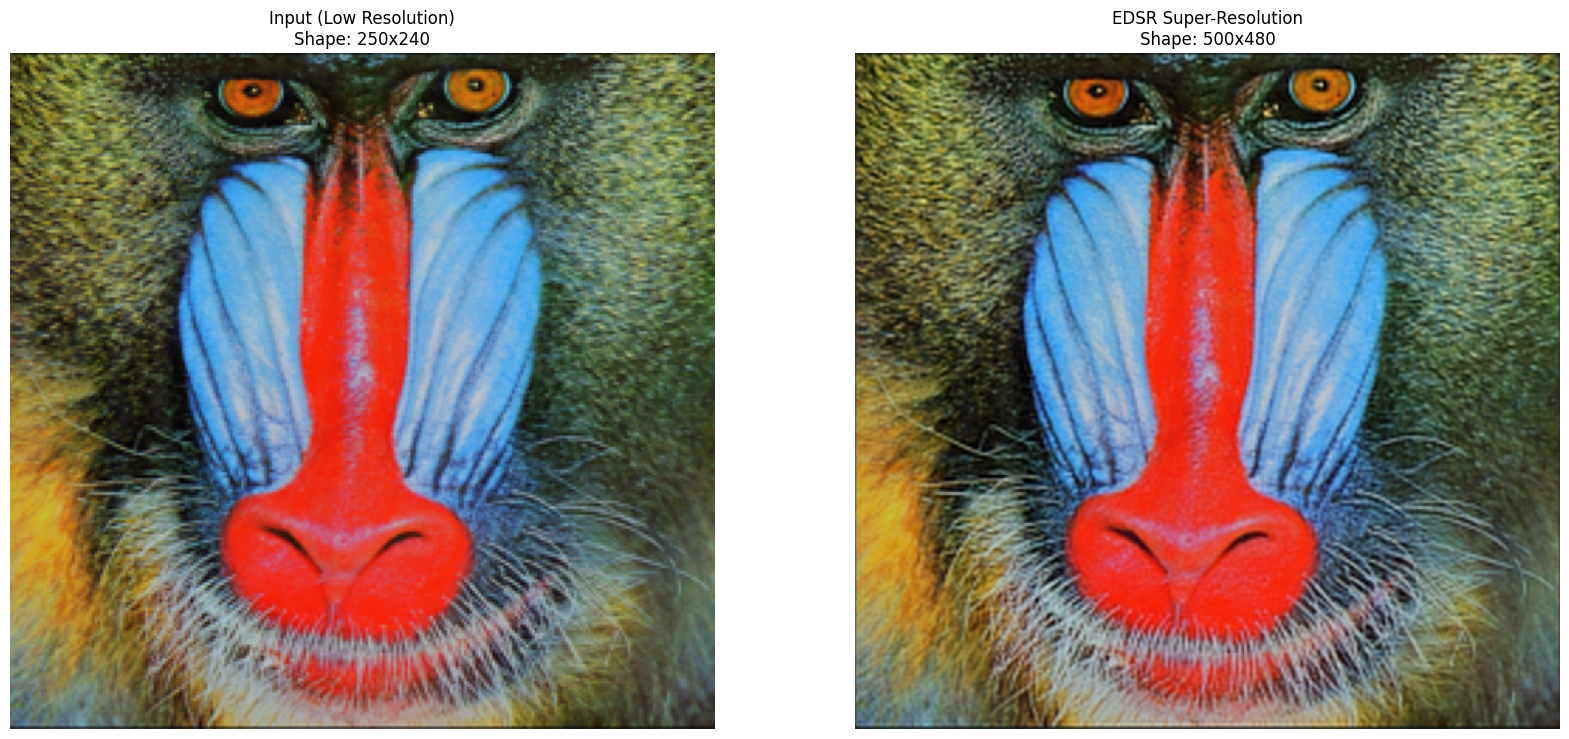

In [ ]:
display_images(low_res_img, super_res_img, low_res_shape, super_res_shape,
                "Input (Low Resolution)", "EDSR Super-Resolution")

In [ ]:
# test the model on a new image
test_image_path = "halfbarbara.png"
low_res_img, super_res_img, low_res_shape, super_res_shape = test_edsr_2x(model, test_image_path, device)

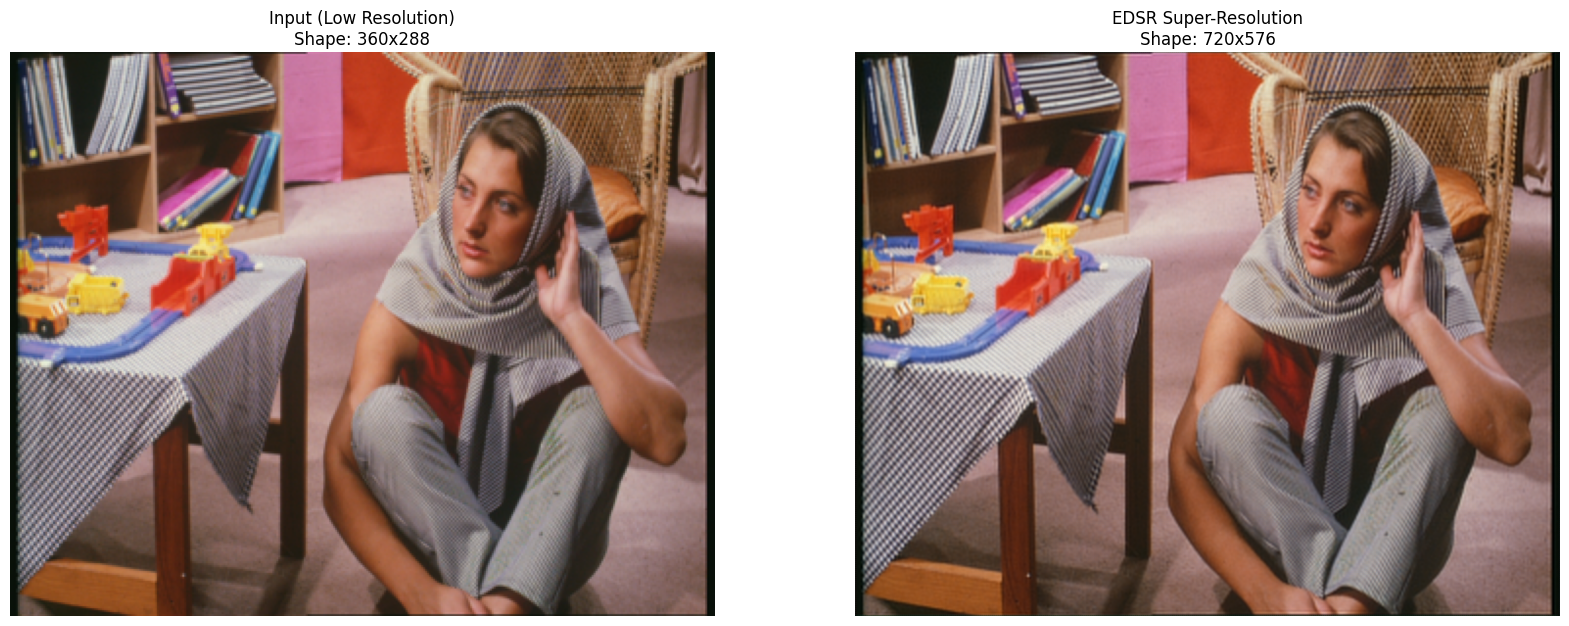

In [ ]:
display_images(low_res_img, super_res_img, low_res_shape, super_res_shape,
                "Input (Low Resolution)", "EDSR Super-Resolution")

In [ ]:
# test the model on a new image
test_image_path = "halfwoman.jpg"
low_res_img, super_res_img, low_res_shape, super_res_shape = test_edsr_2x(model, test_image_path, device)

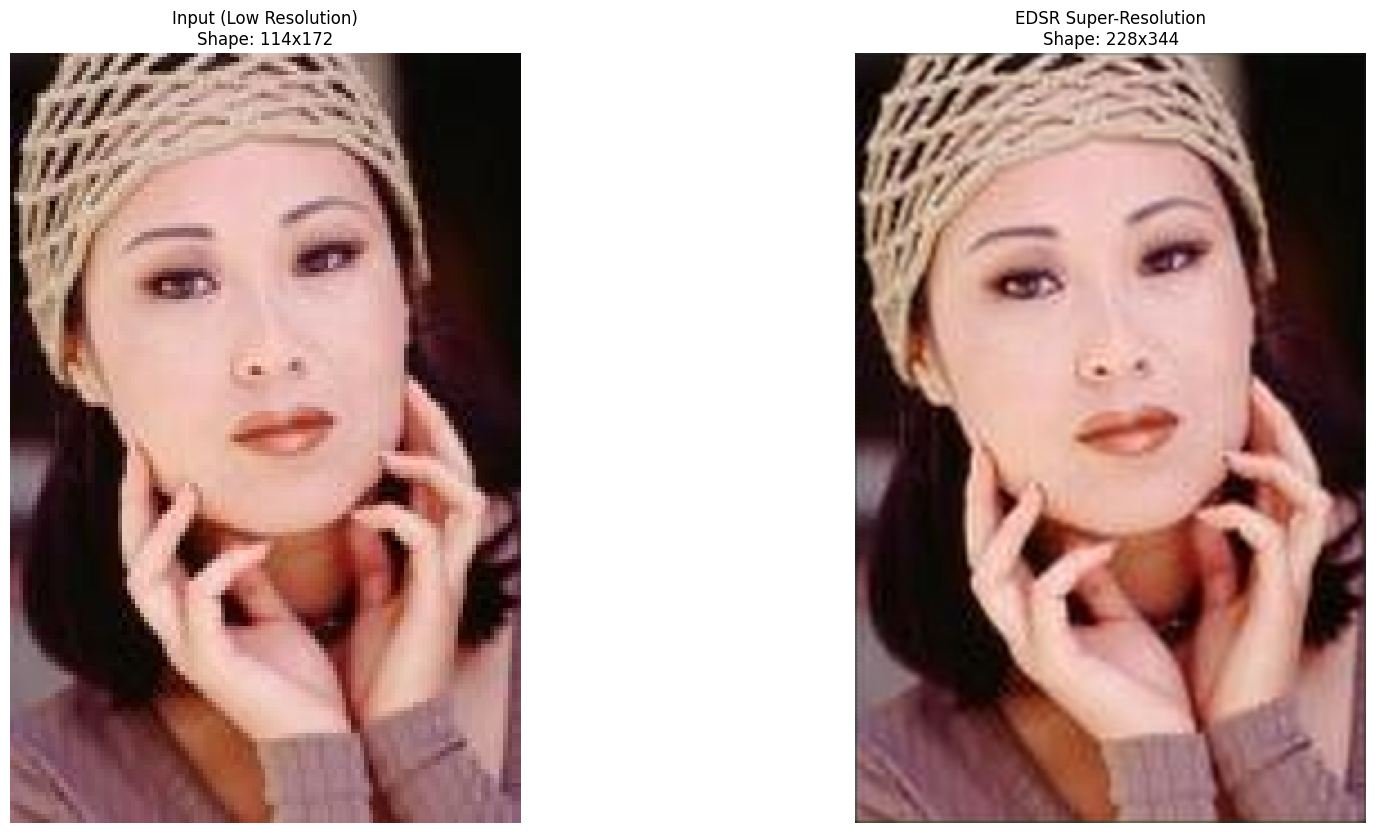

In [ ]:
display_images(low_res_img, super_res_img, low_res_shape, super_res_shape,
                "Input (Low Resolution)", "EDSR Super-Resolution")

## Conclusion

No *edge artifacts* are observed.